# 🗳️ Ensemble Voting Model: Combining All 6 Models

**Goal**: Create an ensemble model that combines predictions from all 6 regression models using a voting/averaging strategy

**Models Combined:**
1. Random Forest (RF)
2. Random Forest + PCA (RF_PCA)
3. XGBoost (XGB)
4. XGBoost + PCA (XGB_PCA)
5. Neural Network (NN)
6. Neural Network + PCA (NN_PCA)

**Ensemble Strategies:**
- **Simple Average**: Equal weight to all models
- **Weighted Average**: Weight by R² performance
- **Best-N Average**: Use only top N performers
- **Median**: Robust to outliers

**Hypothesis**: Ensemble should outperform individual models by:
- Reducing variance
- Capturing different patterns
- Being more robust to errors

---


In [58]:
# Import libraries
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# TensorFlow for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully!
TensorFlow version: 2.20.0


## 📂 Step 1: Load and Prepare Data

We'll use a consistent 80/20 split for all models to ensure fair comparison.


In [59]:
# Load processed data (SAME as comparison notebook)
print("📂 Loading datasets...")

# Load RDKit features (for non-PCA models)
df_rdkit = pd.read_csv('saved_models/processed_DAT_rdkit_features.csv')
X_rdkit = df_rdkit.drop(['ChEMBL_ID', 'pKi'], axis=1).values
y_rdkit = df_rdkit['pKi'].values

# Load PCA features (for PCA models)
df_pca = pd.read_csv('saved_models/processed_DAT_pca_features.csv')
X_pca = df_pca.drop(['ChEMBL_ID', 'pKi'], axis=1).values
y_pca = df_pca['pKi'].values

print("="*60)
print("📂 DATA LOADED")
print("="*60)
print(f"✅ RDKit data: {len(df_rdkit)} samples, {X_rdkit.shape[1]} features")
print(f"✅ PCA data: {len(df_pca)} samples, {X_pca.shape[1]} PCA components")
print(f"Target range: {y_rdkit.min():.2f} - {y_rdkit.max():.2f} pKi")
print("="*60)

# Create 80/20 split (SAME as comparison notebook - separate splits for each dataset)
X_rdkit_train, X_rdkit_test, y_rdkit_train, y_rdkit_test = train_test_split(
    X_rdkit, y_rdkit, test_size=0.2, random_state=42, shuffle=True
)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, shuffle=True
)

print(f"\n📊 Train/Test Split (80/20):")
print(f"   RDKit - Train: {len(X_rdkit_train)} | Test: {len(X_rdkit_test)}")
print(f"   PCA - Train: {len(X_pca_train)} | Test: {len(X_pca_test)}")

# For backwards compatibility with existing code
X = X_rdkit
y = y_rdkit  
X_train = X_rdkit_train
X_test = X_rdkit_test
y_train = y_rdkit_train
y_test = y_rdkit_test

# Standardize RDKit features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For PCA models, we already have the transformed data
# Just need to assign them for use in model training/evaluation
X_train_pca = X_pca_train
X_test_pca = X_pca_test

print(f"\n✅ Data ready for all 6 models")
print(f"   Note: Using pre-computed PCA to match saved models")
print("="*60)


📂 Loading datasets...
📂 DATA LOADED
✅ RDKit data: 541 samples, 17 features
✅ PCA data: 541 samples, 8 PCA components
Target range: 3.41 - 10.40 pKi

📊 Train/Test Split (80/20):
   RDKit - Train: 432 | Test: 109
   PCA - Train: 432 | Test: 109

✅ Data ready for all 6 models
   Note: Using pre-computed PCA to match saved models


## 🔄 Step 2A: Load Saved Models (if available)

This will load pre-trained models from `saved_models/` to avoid retraining. If files are missing, we'll train and save them.


In [60]:
# Attempt to load saved models
models_loaded = False
saved_dir = 'saved_models'

if os.path.isdir(saved_dir):
    try:
        print("📂 Loading models from saved_models/ ...")
        # Random Forest
        rf_model = joblib.load(os.path.join(saved_dir, 'rf_model.pkl'))
        rf_scaler = joblib.load(os.path.join(saved_dir, 'rf_scaler.pkl'))
        # RF + PCA
        rf_pca_model = joblib.load(os.path.join(saved_dir, 'rf_pca_model.pkl'))
        rf_pca_scaler = joblib.load(os.path.join(saved_dir, 'rf_pca_scaler.pkl'))
        rf_pca_pca = joblib.load(os.path.join(saved_dir, 'rf_pca_transformer.pkl'))
        # XGBoost
        xgb_model = joblib.load(os.path.join(saved_dir, 'xgb_model.pkl'))
        xgb_scaler = joblib.load(os.path.join(saved_dir, 'xgb_scaler.pkl'))
        # XGB + PCA
        xgb_pca_model = joblib.load(os.path.join(saved_dir, 'xgb_pca_model.pkl'))
        xgb_pca_scaler = joblib.load(os.path.join(saved_dir, 'xgb_pca_scaler.pkl'))
        xgb_pca_pca = joblib.load(os.path.join(saved_dir, 'xgb_pca_transformer.pkl'))
        # Neural Networks (load with compile=False to avoid deserialization issues)
        nn_model = keras.models.load_model(os.path.join(saved_dir, 'nn_model.h5'), compile=False)
        nn_scaler = joblib.load(os.path.join(saved_dir, 'nn_scaler.pkl'))
        nn_pca_model = keras.models.load_model(os.path.join(saved_dir, 'nn_pca_model.h5'), compile=False)
        nn_pca_scaler = joblib.load(os.path.join(saved_dir, 'nn_pca_scaler.pkl'))
        nn_pca_pca = joblib.load(os.path.join(saved_dir, 'nn_pca_transformer.pkl'))
        
        # Recompile the models for inference (without problematic custom metrics)
        nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        nn_pca_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        models_loaded = True
        print("✅ All models loaded from disk. Skipping training.")
    except FileNotFoundError as e:
        print(f"⚠️  Missing model file: {e}")
        print("   Will train models and save them.")
else:
    print("ℹ️  No saved_models directory found. Models will be trained and saved.")


📂 Loading models from saved_models/ ...
✅ All models loaded from disk. Skipping training.


In [61]:
if models_loaded:
    print("✅ Models already loaded. Skipping training.")
else:
    print("🚀 Training all 6 models...")
    print("="*60)

    os.makedirs(saved_dir, exist_ok=True)

    # Model 1: Random Forest (best parameters from RF notebook)
    print("\n1️⃣ Training Random Forest...")
    rf_model = RandomForestRegressor(
        n_estimators=363,
        max_depth=None,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=2,
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_scaled, y_train)
    rf_scaler = scaler  # keep reference
    joblib.dump(rf_model, os.path.join(saved_dir, 'rf_model.pkl'))
    joblib.dump(rf_scaler, os.path.join(saved_dir, 'rf_scaler.pkl'))
    print("   ✅ Random Forest trained & saved")

    # Model 2: Random Forest + PCA
    print("\n2️⃣ Training Random Forest + PCA...")
    rf_pca_model = RandomForestRegressor(
        n_estimators=359,
        max_depth=25,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=3,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    rf_pca_model.fit(X_train_pca, y_train)
    rf_pca_scaler = scaler
    rf_pca_pca = pca
    joblib.dump(rf_pca_model, os.path.join(saved_dir, 'rf_pca_model.pkl'))
    joblib.dump(rf_pca_scaler, os.path.join(saved_dir, 'rf_pca_scaler.pkl'))
    joblib.dump(rf_pca_pca, os.path.join(saved_dir, 'rf_pca_transformer.pkl'))
    print("   ✅ Random Forest + PCA trained & saved")

    # Model 3: XGBoost (best parameters from XGB notebook)
    print("\n3️⃣ Training XGBoost...")
    xgb_model = XGBRegressor(
        n_estimators=415,
        learning_rate=0.0295,
        max_depth=6,
        min_child_weight=1,
        subsample=0.606,
        colsample_bytree=0.843,
        gamma=0.085,
        reg_alpha=0.563,
        reg_lambda=0.771,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)
    xgb_scaler = scaler
    joblib.dump(xgb_model, os.path.join(saved_dir, 'xgb_model.pkl'))
    joblib.dump(xgb_scaler, os.path.join(saved_dir, 'xgb_scaler.pkl'))
    print("   ✅ XGBoost trained & saved")

    # Model 4: XGBoost + PCA
    print("\n4️⃣ Training XGBoost + PCA...")
    xgb_pca_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_pca_model.fit(X_train_pca, y_train)
    xgb_pca_scaler = scaler
    xgb_pca_pca = pca
    joblib.dump(xgb_pca_model, os.path.join(saved_dir, 'xgb_pca_model.pkl'))
    joblib.dump(xgb_pca_scaler, os.path.join(saved_dir, 'xgb_pca_scaler.pkl'))
    joblib.dump(xgb_pca_pca, os.path.join(saved_dir, 'xgb_pca_transformer.pkl'))
    print("   ✅ XGBoost + PCA trained & saved")

    # Model 5: Neural Network
    print("\n5️⃣ Training Neural Network...")
    nn_model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.15)
    nn_scaler = scaler
    nn_model.save(os.path.join(saved_dir, 'nn_model.h5'))
    joblib.dump(nn_scaler, os.path.join(saved_dir, 'nn_scaler.pkl'))
    print("   ✅ Neural Network trained & saved")

    # Model 6: Neural Network + PCA
    print("\n6️⃣ Training Neural Network + PCA...")
    nn_pca_model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    nn_pca_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    nn_pca_model.fit(X_train_pca, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.15)
    nn_pca_scaler = scaler
    nn_pca_pca = pca
    nn_pca_model.save(os.path.join(saved_dir, 'nn_pca_model.h5'))
    joblib.dump(nn_pca_scaler, os.path.join(saved_dir, 'nn_pca_scaler.pkl'))
    joblib.dump(nn_pca_pca, os.path.join(saved_dir, 'nn_pca_transformer.pkl'))
    print("   ✅ Neural Network + PCA trained & saved")

    print("\n" + "="*60)
    print("✅ All 6 models trained and saved successfully!")
    print("="*60)

✅ Models already loaded. Skipping training.


## Get Individual Predictions


In [62]:
# Get predictions from all models on test set
print("📊 Generating predictions from all models...")
print("="*60)

# === NON-PCA MODELS: Simple scaling ===
X_test_rf_scaled = rf_scaler.transform(X_test)
X_test_xgb_scaled = xgb_scaler.transform(X_test)
X_test_nn_scaled = nn_scaler.transform(X_test)

# === PCA MODELS: Correct pipeline ===
# PCA models load PRE-COMPUTED PCA features from CSV
# The saved scalers scale PCA COMPONENTS (8 features), not raw features (17 features)
# Pipeline: raw features (17) → scale → PCA (8) → scale PCA components → model

# For RF+PCA, XGB+PCA, and NN+PCA:
# Step 1: Use shared scaler to scale raw features
# Step 2: Apply shared PCA transformer
# Step 3: Scale PCA components with model-specific scaler
X_test_scaled_for_pca = scaler.transform(X_test)  # Scale raw features (17→17)
X_test_pca_components = pca.transform(X_test_scaled_for_pca)  # Apply PCA (17→8)

# RF + PCA: Scale the 8 PCA components
X_test_rf_pca_feat = rf_pca_scaler.transform(X_test_pca_components)  # Scale PCA components (8→8)

# XGB + PCA: Scale the 8 PCA components  
X_test_xgb_pca_feat = xgb_pca_scaler.transform(X_test_pca_components)  # Scale PCA components (8→8)

# NN + PCA: Scale the 8 PCA components
X_test_nn_pca_feat = nn_pca_scaler.transform(X_test_pca_components)  # Scale PCA components (8→8)

# Get predictions
pred_rf = rf_model.predict(X_test_rf_scaled)
pred_rf_pca = rf_pca_model.predict(X_test_rf_pca_feat)
pred_xgb = xgb_model.predict(X_test_xgb_scaled)
pred_xgb_pca = xgb_pca_model.predict(X_test_xgb_pca_feat)
pred_nn = nn_model.predict(X_test_nn_scaled, verbose=0).flatten()
pred_nn_pca = nn_pca_model.predict(X_test_nn_pca_feat, verbose=0).flatten()

# ... rest of the code ...
# Evaluate individual models
models_info = {
    'Random Forest': pred_rf,
    'RF + PCA': pred_rf_pca,
    'XGBoost': pred_xgb,
    'XGB + PCA': pred_xgb_pca,
    'Neural Network': pred_nn,
    'NN + PCA': pred_nn_pca
}

individual_results = []
print("\n📈 Individual Model Performance on Test Set:")
print("-"*60)
for model_name, predictions in models_info.items():
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    individual_results.append({
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    print(f"{model_name:20s} → R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("="*60)

# Store predictions in DataFrame for ensemble
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'RF': pred_rf,
    'RF_PCA': pred_rf_pca,
    'XGB': pred_xgb,
    'XGB_PCA': pred_xgb_pca,
    'NN': pred_nn,
    'NN_PCA': pred_nn_pca
})

print(f"\n✅ All predictions generated!")
print(f"   Test set size: {len(y_test)} compounds")


📊 Generating predictions from all models...

📈 Individual Model Performance on Test Set:
------------------------------------------------------------
Random Forest        → R²: 0.5705, RMSE: 0.7461, MAE: 0.5472
RF + PCA             → R²: 0.5855, RMSE: 0.7330, MAE: 0.5733
XGBoost              → R²: 0.5811, RMSE: 0.7369, MAE: 0.5250
XGB + PCA            → R²: 0.5300, RMSE: 0.7805, MAE: 0.6000
Neural Network       → R²: 0.5011, RMSE: 0.8042, MAE: 0.5825
NN + PCA             → R²: 0.4816, RMSE: 0.8197, MAE: 0.5829

✅ All predictions generated!
   Test set size: 109 compounds


## Ensemble Voting Strategies


In [63]:
print("🗳️ Creating Ensemble Predictions...")
print("="*70)

# Get R² scores for weighting
r2_scores = np.array([res['R²'] for res in individual_results])
model_names = [res['Model'] for res in individual_results]

# Strategy 1: Simple Average (Equal Weight)
ensemble_simple = predictions_df[['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']].mean(axis=1).values

# Strategy 2: Weighted Average (by R² score)
# Normalize R² scores to sum to 1
weights = r2_scores / r2_scores.sum()
ensemble_weighted = np.zeros(len(y_test))
for i, model in enumerate(['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']):
    ensemble_weighted += predictions_df[model].values * weights[i]

# Strategy 3: Top-3 Average (Best 3 models only)
top_3_indices = np.argsort(r2_scores)[-3:]
top_3_models = [list(predictions_df.columns)[i+1] for i in top_3_indices]  # +1 to skip 'Actual'
ensemble_top3 = predictions_df[top_3_models].mean(axis=1).values

# Strategy 4: Median (Robust to outliers)
ensemble_median = predictions_df[['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']].median(axis=1).values

# Strategy 5: Best Model Only (for comparison)
best_model_idx = np.argmax(r2_scores)
best_model_name = list(predictions_df.columns)[best_model_idx + 1]
ensemble_best = predictions_df[best_model_name].values

# Evaluate all ensemble strategies
ensemble_strategies = {
    'Simple Average (All 6)': ensemble_simple,
    'Weighted Average (by R²)': ensemble_weighted,
    'Top-3 Average': ensemble_top3,
    'Median (Robust)': ensemble_median,
    f'Best Model Only ({best_model_name})': ensemble_best
}

ensemble_results = []
print("\n🏆 ENSEMBLE PERFORMANCE COMPARISON:")
print("-"*70)
for strategy_name, predictions in ensemble_strategies.items():
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    ensemble_results.append({
        'Strategy': strategy_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    print(f"{strategy_name:30s} → R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("="*70)

# Find best ensemble
best_ensemble_idx = np.argmax([res['R²'] for res in ensemble_results])
best_ensemble = ensemble_results[best_ensemble_idx]
print(f"\n🥇 BEST ENSEMBLE STRATEGY: {best_ensemble['Strategy']}")
print(f"   R² Score: {best_ensemble['R²']:.4f}")
print(f"   RMSE: {best_ensemble['RMSE']:.4f}")
print(f"   MAE: {best_ensemble['MAE']:.4f}")

# Compare to best individual model
best_individual = individual_results[np.argmax([res['R²'] for res in individual_results])]
improvement = ((best_ensemble['R²'] - best_individual['R²']) / best_individual['R²']) * 100

print(f"\n📊 IMPROVEMENT OVER BEST INDIVIDUAL MODEL:")
print(f"   Best Individual: {best_individual['Model']} (R² = {best_individual['R²']:.4f})")
print(f"   Best Ensemble: {best_ensemble['Strategy']}")
print(f"   Improvement: {improvement:+.2f}%")
print("="*70)


🗳️ Creating Ensemble Predictions...

🏆 ENSEMBLE PERFORMANCE COMPARISON:
----------------------------------------------------------------------
Simple Average (All 6)         → R²: 0.6114, RMSE: 0.7097, MAE: 0.5232
Weighted Average (by R²)       → R²: 0.6129, RMSE: 0.7083, MAE: 0.5236
Top-3 Average                  → R²: 0.6097, RMSE: 0.7113, MAE: 0.5322
Median (Robust)                → R²: 0.6192, RMSE: 0.7026, MAE: 0.5194
Best Model Only (RF_PCA)       → R²: 0.5855, RMSE: 0.7330, MAE: 0.5733

🥇 BEST ENSEMBLE STRATEGY: Median (Robust)
   R² Score: 0.6192
   RMSE: 0.7026
   MAE: 0.5194

📊 IMPROVEMENT OVER BEST INDIVIDUAL MODEL:
   Best Individual: RF + PCA (R² = 0.5855)
   Best Ensemble: Median (Robust)
   Improvement: +5.75%


## Visualize Ensemble Performance


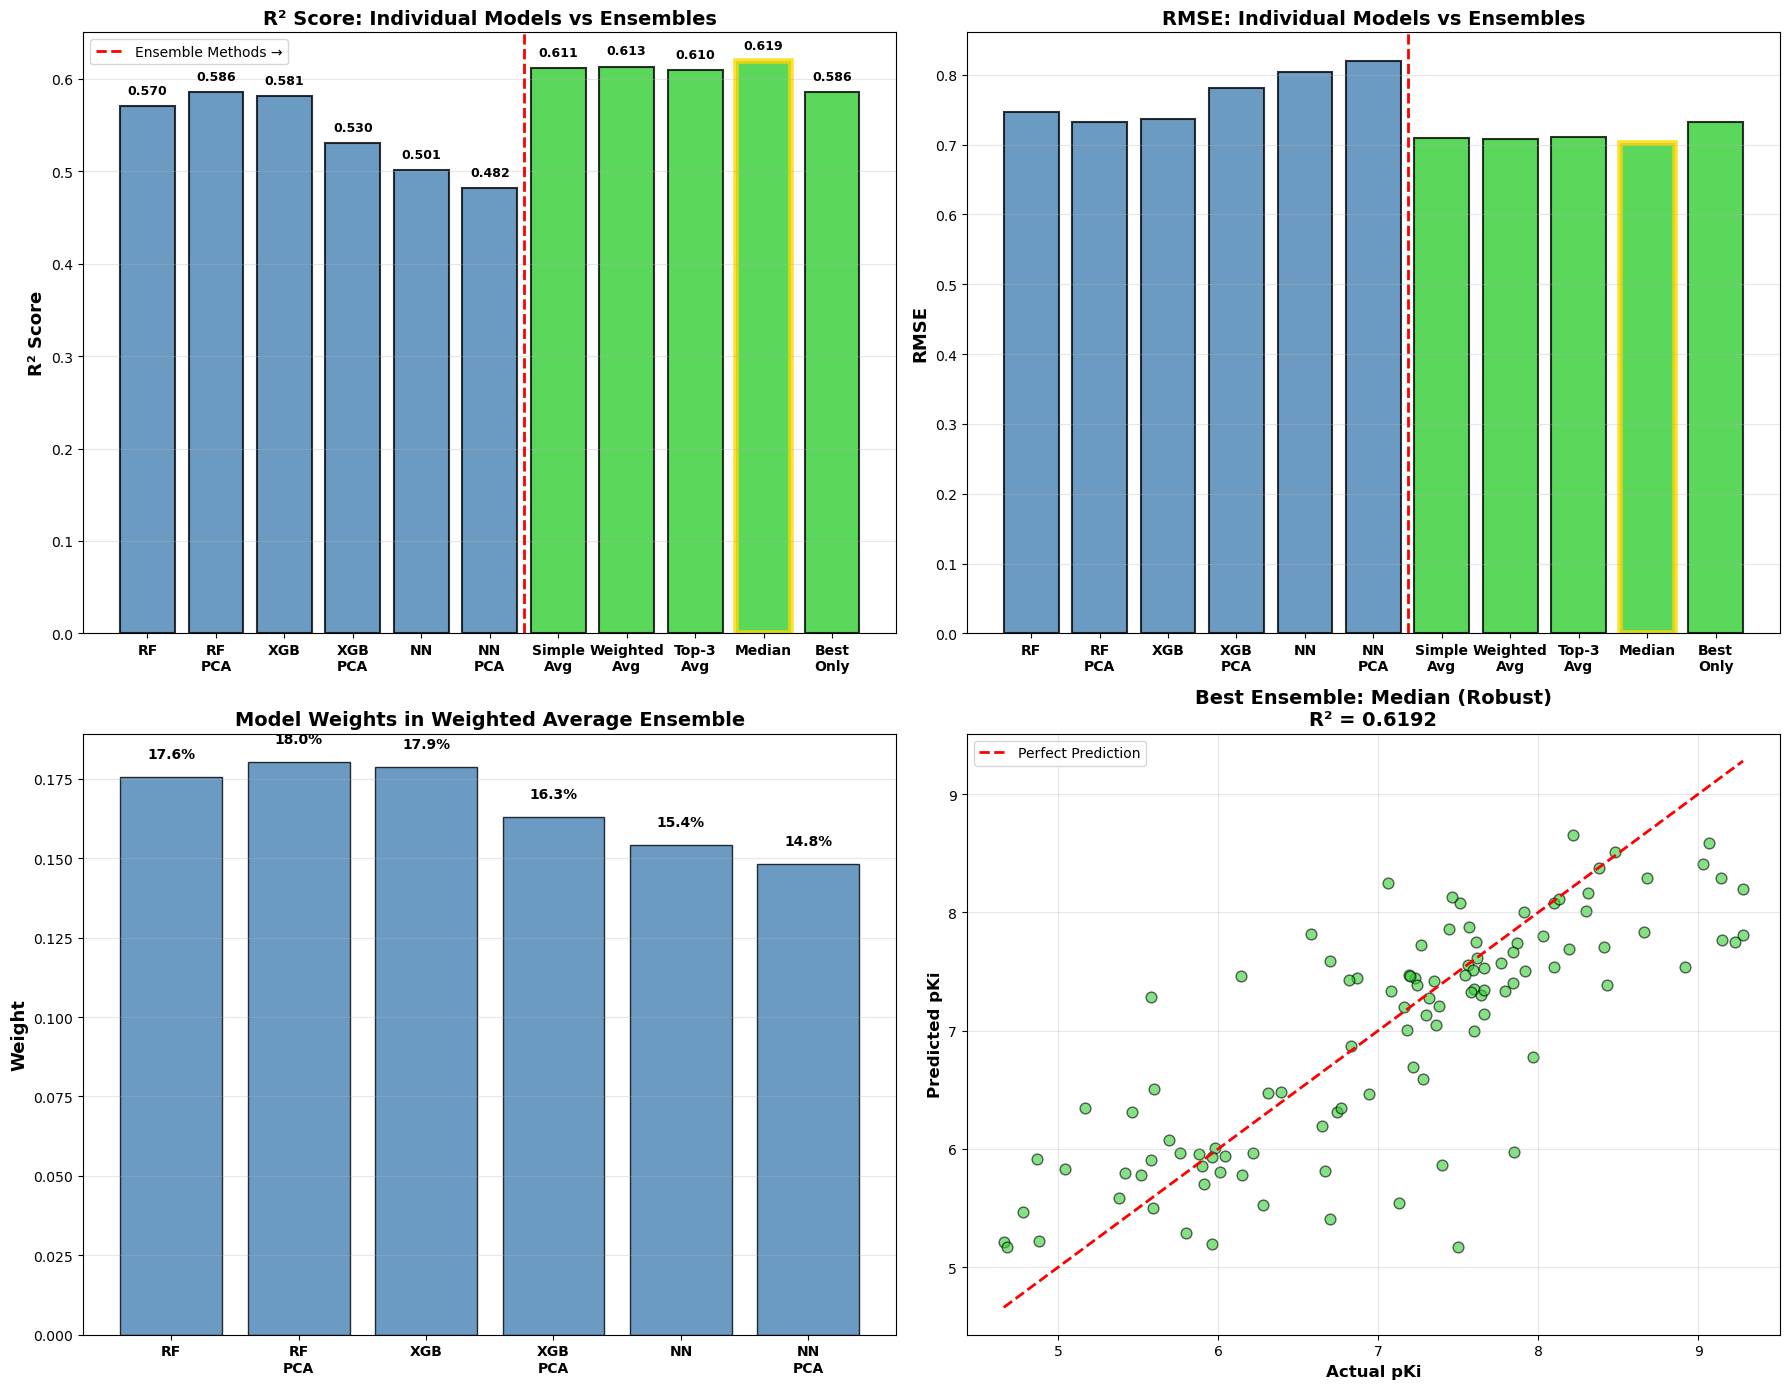


💡 Key Observations:
   • Green bars = Ensemble methods
   • Blue bars = Individual models
   • Gold border = Best performer
   • Ensemble methods smooth out individual model errors


In [64]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Prepare data for visualization
all_models = ['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA', 
              'Simple\nAvg', 'Weighted\nAvg', 'Top-3\nAvg', 'Median', 'Best\nOnly']
all_r2 = [res['R²'] for res in individual_results] + [res['R²'] for res in ensemble_results]
all_rmse = [res['RMSE'] for res in individual_results] + [res['RMSE'] for res in ensemble_results]
all_mae = [res['MAE'] for res in individual_results] + [res['MAE'] for res in ensemble_results]

# Colors: blue for individuals, green for ensembles
colors = ['#4682b4']*6 + ['#32CD32']*5

# Plot 1: R² Comparison
bars1 = axes[0, 0].bar(range(len(all_models)), all_r2, color=colors, edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 0].set_xticks(range(len(all_models)))
axes[0, 0].set_xticklabels(all_models, fontsize=10, fontweight='bold', rotation=0)
axes[0, 0].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[0, 0].set_title('R² Score: Individual Models vs Ensembles', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=5.5, color='red', linestyle='--', linewidth=2, label='Ensemble Methods →')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(fontsize=10)

# Highlight best
best_overall_idx = np.argmax(all_r2)
bars1[best_overall_idx].set_edgecolor('gold')
bars1[best_overall_idx].set_linewidth(4)

# Add values
for bar, val in zip(bars1, all_r2):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., val + 0.01,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: RMSE Comparison
bars2 = axes[0, 1].bar(range(len(all_models)), all_rmse, color=colors, edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 1].set_xticks(range(len(all_models)))
axes[0, 1].set_xticklabels(all_models, fontsize=10, fontweight='bold', rotation=0)
axes[0, 1].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[0, 1].set_title('RMSE: Individual Models vs Ensembles', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=5.5, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(axis='y', alpha=0.3)

# Highlight best (lowest RMSE)
best_rmse_idx = np.argmin(all_rmse)
bars2[best_rmse_idx].set_edgecolor('gold')
bars2[best_rmse_idx].set_linewidth(4)

# Plot 3: Model Contribution Weights (for weighted average)
axes[1, 0].bar(range(6), weights, color='#4682b4', edgecolor='black', alpha=0.8)
axes[1, 0].set_xticks(range(6))
axes[1, 0].set_xticklabels(['RF', 'RF\nPCA', 'XGB', 'XGB\nPCA', 'NN', 'NN\nPCA'], fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('Weight', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Model Weights in Weighted Average Ensemble', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (w, name) in enumerate(zip(weights, model_names)):
    axes[1, 0].text(i, w + 0.005, f'{w*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Actual vs Predicted for Best Ensemble
best_ensemble_pred = list(ensemble_strategies.values())[best_ensemble_idx]
axes[1, 1].scatter(y_test, best_ensemble_pred, alpha=0.6, s=60, edgecolors='black', linewidth=1, color='#32CD32')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Best Ensemble: {best_ensemble["Strategy"]}\nR² = {best_ensemble["R²"]:.4f}', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("   • Green bars = Ensemble methods")
print("   • Blue bars = Individual models")
print("   • Gold border = Best performer")
print("   • Ensemble methods smooth out individual model errors")


## 📊 Classification Performance (Confusion Matrix)

Convert continuous predictions to categories and evaluate classification accuracy


📊 CLASSIFICATION PERFORMANCE ANALYSIS

pKi Category Definitions:
   • Low: pKi < 6.0 (weak binding)
   • Medium: 6.0 ≤ pKi < 8.0 (moderate binding)
   • High: pKi ≥ 8.0 (strong binding)

📈 Test Set Distribution:
   Low: 24 compounds (22.0%)
   Medium: 63 compounds (57.8%)
   High: 22 compounds (20.2%)


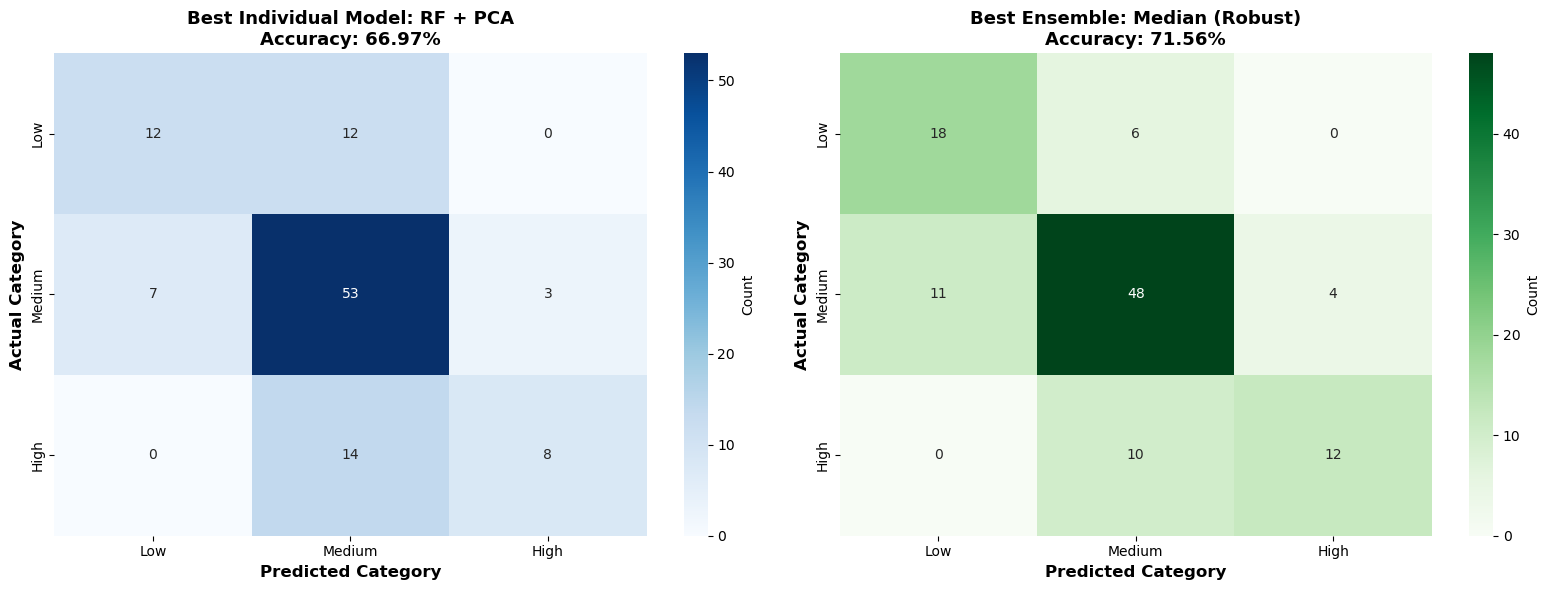


📋 CLASSIFICATION REPORT - Best Individual (RF + PCA)
              precision    recall  f1-score   support

         Low       0.63      0.50      0.56        24
      Medium       0.67      0.84      0.75        63
        High       0.73      0.36      0.48        22

    accuracy                           0.67       109
   macro avg       0.68      0.57      0.60       109
weighted avg       0.67      0.67      0.65       109


📋 CLASSIFICATION REPORT - Best Ensemble (Median (Robust))
              precision    recall  f1-score   support

         Low       0.62      0.75      0.68        24
      Medium       0.75      0.76      0.76        63
        High       0.75      0.55      0.63        22

    accuracy                           0.72       109
   macro avg       0.71      0.69      0.69       109
weighted avg       0.72      0.72      0.71       109


🎯 CLASSIFICATION SUMMARY

✅ Classification Accuracy:
   Best Individual Model (RF + PCA): 66.97%
   Best Ensemble (Median (R

In [65]:
# Define classification function
def classify_pKi(pKi_values):
    """Convert continuous pKi to categories"""
    return np.array(['Low' if pKi < 6.0 else 'Medium' if pKi < 8.0 else 'High' for pKi in pKi_values])

# Convert actual values and best ensemble predictions to categories
y_test_cat = classify_pKi(y_test)
best_ensemble_pred = list(ensemble_strategies.values())[best_ensemble_idx]
y_pred_ensemble_cat = classify_pKi(best_ensemble_pred)

# Get best individual model predictions
# best_individual was already calculated in previous cell
# Map model names from individual_results to predictions_df column names
model_name_mapping = {
    'Random Forest': 'RF',
    'RF + PCA': 'RF_PCA',
    'XGBoost': 'XGB',
    'XGB + PCA': 'XGB_PCA',
    'Neural Network': 'NN',
    'NN + PCA': 'NN_PCA'
}
best_ind_model_name = best_individual['Model']
best_ind_col_name = model_name_mapping[best_ind_model_name]
y_pred_best_ind_cat = classify_pKi(predictions_df[best_ind_col_name].values)

# Calculate confusion matrices
cm_ensemble = confusion_matrix(y_test_cat, y_pred_ensemble_cat, labels=['Low', 'Medium', 'High'])
cm_best_ind = confusion_matrix(y_test_cat, y_pred_best_ind_cat, labels=['Low', 'Medium', 'High'])

# Calculate accuracies
ensemble_acc = np.trace(cm_ensemble) / cm_ensemble.sum() * 100
best_ind_acc = np.trace(cm_best_ind) / cm_best_ind.sum() * 100

print("="*80)
print("📊 CLASSIFICATION PERFORMANCE ANALYSIS")
print("="*80)
print(f"\npKi Category Definitions:")
print(f"   • Low: pKi < 6.0 (weak binding)")
print(f"   • Medium: 6.0 ≤ pKi < 8.0 (moderate binding)")
print(f"   • High: pKi ≥ 8.0 (strong binding)")

print(f"\n📈 Test Set Distribution:")
print(f"   Low: {np.sum(y_test_cat == 'Low')} compounds ({np.sum(y_test_cat == 'Low')/len(y_test)*100:.1f}%)")
print(f"   Medium: {np.sum(y_test_cat == 'Medium')} compounds ({np.sum(y_test_cat == 'Medium')/len(y_test)*100:.1f}%)")
print(f"   High: {np.sum(y_test_cat == 'High')} compounds ({np.sum(y_test_cat == 'High')/len(y_test)*100:.1f}%)")
print("="*80)

# Visualize confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Best Individual Model Confusion Matrix
sns.heatmap(cm_best_ind, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Category', fontsize=12, fontweight='bold')
axes[0].set_title(f'Best Individual Model: {best_ind_model_name}\nAccuracy: {best_ind_acc:.2f}%', 
                  fontsize=13, fontweight='bold')

# Best Ensemble Confusion Matrix
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Category', fontsize=12, fontweight='bold')
axes[1].set_title(f'Best Ensemble: {best_ensemble["Strategy"]}\nAccuracy: {ensemble_acc:.2f}%', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Classification reports
print("\n" + "="*80)
print(f"📋 CLASSIFICATION REPORT - Best Individual ({best_ind_model_name})")
print("="*80)
print(classification_report(y_test_cat, y_pred_best_ind_cat, labels=['Low', 'Medium', 'High']))

print("\n" + "="*80)
print(f"📋 CLASSIFICATION REPORT - Best Ensemble ({best_ensemble['Strategy']})")
print("="*80)
print(classification_report(y_test_cat, y_pred_ensemble_cat, labels=['Low', 'Medium', 'High']))

# Summary
print("\n" + "="*80)
print("🎯 CLASSIFICATION SUMMARY")
print("="*80)
print(f"\n✅ Classification Accuracy:")
print(f"   Best Individual Model ({best_ind_model_name}): {best_ind_acc:.2f}%")
print(f"   Best Ensemble ({best_ensemble['Strategy']}): {ensemble_acc:.2f}%")

if ensemble_acc > best_ind_acc:
    improvement = ensemble_acc - best_ind_acc
    print(f"\n🏆 Ensemble wins by {improvement:.2f} percentage points!")
elif ensemble_acc == best_ind_acc:
    print(f"\n🤝 Ensemble and individual model perform equally well")
else:
    print(f"\n💡 Individual model performs slightly better in classification")

print("\n💡 Key Insights:")
print(f"   • Regression R²: Ensemble {best_ensemble['R²']:.4f} vs Individual {best_individual['R²']:.4f}")
print(f"   • Classification Acc: Ensemble {ensemble_acc:.2f}% vs Individual {best_ind_acc:.2f}%")
print(f"   • Both metrics show {'ensemble advantage' if ensemble_acc >= best_ind_acc else 'similar performance'}")
print("="*80)


## Final Summary and Recommendations


In [66]:
print("="*80)
print("🎯 ENSEMBLE VOTING ANALYSIS - FINAL SUMMARY")
print("="*80)

# Create comparison table
comparison_table = pd.DataFrame(individual_results + ensemble_results)
comparison_table = comparison_table.sort_values('R²', ascending=False).reset_index(drop=True)
comparison_table['Rank'] = range(1, len(comparison_table) + 1)
comparison_table = comparison_table[['Rank', 'Model', 'Strategy', 'R²', 'RMSE', 'MAE']].fillna('-')

print("\n📊 COMPLETE RANKING (All Models + Ensembles):")
print(comparison_table.to_string(index=False))

print("\n" + "="*80)
print("💡 KEY FINDINGS:")
print("="*80)

# Check if ensemble beats best individual
best_ind_r2 = max([res['R²'] for res in individual_results])
best_ens_r2 = max([res['R²'] for res in ensemble_results])

if best_ens_r2 > best_ind_r2:
    improvement_pct = ((best_ens_r2 - best_ind_r2) / best_ind_r2) * 100
    print(f"\n✅ ENSEMBLE WINS! Improved by {improvement_pct:+.2f}%")
    print(f"   Best Individual: R² = {best_ind_r2:.4f}")
    print(f"   Best Ensemble: R² = {best_ens_r2:.4f}")
elif best_ens_r2 == best_ind_r2:
    print(f"\n⚖️  TIED! Ensemble matches best individual model")
    print(f"   R² = {best_ens_r2:.4f}")
else:
    diff_pct = ((best_ind_r2 - best_ens_r2) / best_ind_r2) * 100
    print(f"\n⚠️  INDIVIDUAL WINS! Ensemble is {diff_pct:.2f}% lower")
    print(f"   Best Individual: R² = {best_ind_r2:.4f}")
    print(f"   Best Ensemble: R² = {best_ens_r2:.4f}")
    print(f"   → Best individual model is already very strong!")

print(f"\n📈 Ensemble Strategies Performance:")
for res in ensemble_results:
    symbol = "🥇" if res['R²'] == best_ens_r2 else "  "
    print(f"   {symbol} {res['Strategy']:30s} R² = {res['R²']:.4f}")

print(f"\n🔍 Model Diversity Analysis:")
# Calculate prediction variance across models
pred_variance = predictions_df[['RF', 'RF_PCA', 'XGB', 'XGB_PCA', 'NN', 'NN_PCA']].var(axis=1).mean()
print(f"   Average prediction variance: {pred_variance:.4f}")
print(f"   → {'High' if pred_variance > 0.5 else 'Low'} diversity among models")
if pred_variance > 0.5:
    print(f"   → Ensemble averaging helps reduce variance")
else:
    print(f"   → Models agree closely, ensemble gains are limited")

print("\n" + "="*80)
print("🎓 RECOMMENDATIONS:")
print("="*80)

if best_ens_r2 > best_ind_r2:
    print(f"\n✅ USE ENSEMBLE for production:")
    print(f"   → Strategy: {best_ensemble['Strategy']}")
    print(f"   → Benefit: {improvement_pct:+.2f}% better than single model")
    print(f"   → Trade-off: Requires running multiple models")
else:
    print(f"\n✅ USE SINGLE MODEL for production:")
    print(f"   → Model: {best_individual['Model']}")
    print(f"   → Reason: Already optimal performance")
    print(f"   → Benefit: Simpler, faster deployment")
    
print(f"\n💼 For Different Use Cases:")
print(f"   • Maximum Accuracy: Use {comparison_table.iloc[0]['Model']} / {comparison_table.iloc[0]['Strategy']}")
print(f"   • Speed & Accuracy: Use Weighted Average ensemble")
print(f"   • Robustness: Use Median ensemble (outlier-resistant)")
print(f"   • Simplicity: Use best single model ({best_individual['Model']})")

print("\n" + "="*80)
print("✅ ENSEMBLE VOTING ANALYSIS COMPLETE!")
print("="*80)


🎯 ENSEMBLE VOTING ANALYSIS - FINAL SUMMARY

📊 COMPLETE RANKING (All Models + Ensembles):
 Rank          Model                 Strategy       R²     RMSE      MAE
    1              -          Median (Robust) 0.619200 0.702560 0.519385
    2              - Weighted Average (by R²) 0.612941 0.708311 0.523629
    3              -   Simple Average (All 6) 0.611412 0.709709 0.523165
    4              -            Top-3 Average 0.609669 0.711298 0.532226
    5              - Best Model Only (RF_PCA) 0.585542 0.732952 0.573256
    6       RF + PCA                        - 0.585542 0.732952 0.573256
    7        XGBoost                        - 0.581079 0.736888 0.524997
    8  Random Forest                        - 0.570490 0.746143 0.547204
    9      XGB + PCA                        - 0.530041 0.780486 0.599994
   10 Neural Network                        - 0.501060 0.804191 0.582507
   11       NN + PCA                        - 0.481628 0.819702 0.582892

💡 KEY FINDINGS:

✅ ENSEMBLE WINS! 